In [61]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [62]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

In [57]:
test = pd.read_csv('test.csv')

In [77]:
X = train.drop('smoking', axis=1)
y = train['smoking']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(test)

# Define individual classifiers
rf_clf = RandomForestClassifier(
    n_estimators=390,
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
logistic_clf = LogisticRegression(max_iter=10000,
                                 C=0.01,
                                 random_state=1)
svm_clf = SVC(probability=True, random_state=1)  # probability=True for soft voting

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('random_forest', rf_clf),
        ('logistic', logistic_clf),
        ('svm', svm_clf)
    ],
    voting='soft'  # Use 'soft' voting for probability averaging
)

# Fit the voting classifier on the scaled training data
voting_clf.fit(X_train_scaled, y_train)

# Predict and evaluate on test set
#y_pred_proba = voting_clf.predict_proba(test_scaled)[:, 1]
#
## 12. Bashoratlarni saqlash
#subm = pd.read_csv("sample_submission.csv")
#subm['smoking'] = y_pred_proba
#subm.to_csv("my_submission_1.csv", index=False)

# Predict probabilities and evaluate
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("Voting Classifier ROC-AUC Score:", roc_auc)

y_pred_proba = voting_clf.predict_proba(X_train_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_proba)
print("Voting Classifier ROC-AUC Score train:", roc_auc_train)




Voting Classifier ROC-AUC Score: 0.884915685705011
Voting Classifier ROC-AUC Score train: 0.9465499275481875


Simple: Voting Classifier ROC-AUC Score: 0.8843646956313748
        Voting Classifier ROC-AUC Score train: 0.9738917858830574
with hyperparametr: Voting Classifier ROC-AUC Score: 0.884915685705011
                        Voting Classifier ROC-AUC Score train: 0.9465499275481875

### Submission: 0.89385


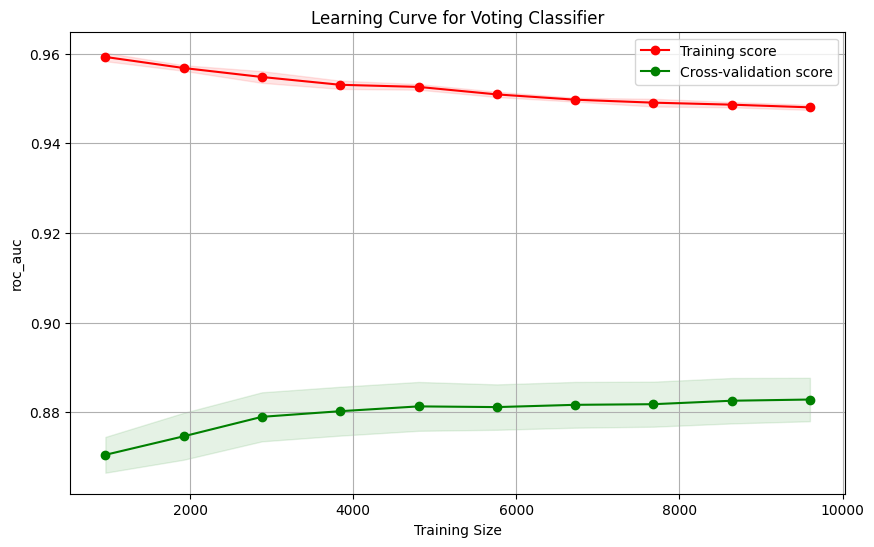

In [78]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot the learning curve
def plot_learning_curve(estimator, X, y, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )

    # Calculate mean and standard deviation for train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.title('Learning Curve for Voting Classifier')
    plt.xlabel('Training Size')
    plt.ylabel(scoring)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curve for the voting classifier
plot_learning_curve(voting_clf, X_train_scaled, y_train, cv=5, scoring='roc_auc')
